# Homework 3: Evaluation of Predictive Models

This exercise should guide you through performing a predictive modeling analysis.  You will choose a model type, set critical complexity parameters, and apply it to select prospects for a direct mailing charity campaign.

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
import sys

import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')
plt.rcParams['figure.figsize'] = 10, 8

sys.path.append("..")

# tools for loading a few toy datasets
from ds_utils.sample_data import *

In [27]:
from sklearn.model_selection import train_test_split

X, y = get_mailing_data()
X_mailing_train, X_mailing_test, y_mailing_train, y_mailing_use_secret = train_test_split(X, y, train_size=.75, test_size=.25, random_state=42)

Mailing marketing offers can be costly.  We want to send out solicitations for donations; each solicitation costs us $2.00. Consider the examples above which are taken from a real direct marketing campaign. Each record (X) represents an individual who was targeted with a direct marketing offer. The offer was a solicitation to make a charitable donation. The features for each example represent various features related to an individual's financial data and prior donation activity, the target (y) value is 1 if the person responded to the mailer, and 0 otherwise.

You will analyze (at least) three algorithms for these data: tree induction, logistic regression, and any other method of your choice.  Your ultimate goal is to build the _best_ model given the data and to do some analytics on the model.  You have a budget of $3000, and you will decide how to spend that on targeting. 

The task here is to simulate a realistic scenario where you are tuning a model on data you have available (here `X_mailing_train` and `y_mailing_train`) and then deploying that model on future unseen data (here `X_mailing_use` and `y_mailing_use_secret`), observing how it performs "in the wild".  We've called the labels for the "use" `y_mailing_use_secret` to emphasize that you really would not know these.  So don't make any modeling decisions based on them--just use them for your evaluations.  Think about this as actually running the campaign with the choices you have made, and then evaluating the result.  SO... for making modeling choices (including selecting what algorithm to use and what you think it's AUC will be) you can use cross-validation on the training data (suggested below).

**1.** Using cross validation on the training data, build 3 different types of models, tuning the appropriate complexity parameters to find a complexity that you think will give you a large area under the ROC curve (AUC). Models to build are:
- A [`DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).
- A [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier. 
- A classifier of your choosing. Some possibilites to consider are the [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), the [`KNeighborsClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), and the deep learning approach [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) (MLP stands for Multi-layer perceptron). Feel free to explore sklearn and pick a model you're happy with. 

Describe the process you went through to identify the complexity parameters tuned and the process used to tune them. Print those parameters and AUC (still not using the "secret" data!) for the models you've chosen. Pick one model that you'll use going forward. Why did you pick this model?\n

**Note:** not all sklearn classifiers can emit probabilities by default. Be sure to check the documentation and make the appropriate settings. Using the `predict_proba` method will be important later.
Also: It isn't expected that you'll find the best possible model. Limit the number of hyper-parameters you evaluate so that time spent computing is constrained. Be concious that some more complex models take longer to train! You may want to do some test runs to try and estimate how long model training will take. 

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# scaler = StandardScaler(copy=True)
# # we have created a standardization based on the training data
# X_clean = scaler.fit(X_mailing_train).transform(X_mailing_train)

## Models used:
    - RandomForest
    - DecisionTree
    - Logistic Regression

In [32]:
#RandomForestClassifier
grid = {"n_estimators": [ 15, 50, 60, 70, 90],
    "max_depth": [ 15, 20, 25],
    "min_samples_leaf": [ 50, 70, 90, 110] }

tuned_model = GridSearchCV(RandomForestClassifier(), grid, scoring="roc_auc")
tuned_model.fit(X_clean, y_mailing_train)

print ("Best roc_auc: %0.3f, using: " % tuned_model.best_score_)
print (tuned_model.best_params_)

Best roc_auc: 0.612, using: 
{'n_estimators': 60, 'max_depth': 15, 'min_samples_leaf': 90}


In [31]:
#DecisionTreeClassifier
grid1 = {
    "max_depth": [1,2, 5, 10, 15, 20,25],
    "min_samples_leaf": [ 120,150,200,300, 400] }

tuned_model1 = GridSearchCV(DecisionTreeClassifier(), grid1, scoring="roc_auc")
tuned_model1.fit(X_clean, y_mailing_train)

print ("Best roc_auc: %0.3f, using: " % tuned_model1.best_score_)
print (tuned_model1.best_params_)

Best roc_auc: 0.600, using: 
{'max_depth': 5, 'min_samples_leaf': 300}


In [7]:
#LogisticRegression
grid2 = {
    "C": [0.1,.01,.001,1,10, 100 , 150, 200] }

tuned_model2 = GridSearchCV(LogisticRegression(), grid2, scoring="roc_auc")
tuned_model2.fit(X_clean, y_mailing_train)

print ("Best roc_auc: %0.3f, using: " % tuned_model2.best_score_)
print (tuned_model2.best_params_)

Best roc_auc: 0.614, using: 
{'C': 150}


**2.** Apply your selected model to the use data (`X_mailing_use` and `y_mailing_use_secret`), outputting the predicted probability of the 1's class. Ranking examples by this probability score, plot the lift curve of your model as compared to simple random selection.

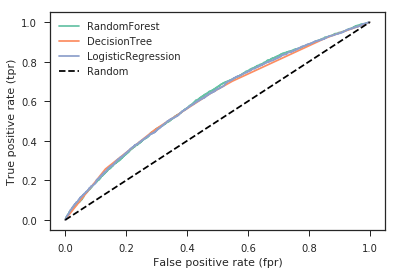

In [33]:
# Get the probability of Y_test records being = 1
RF_predict = tuned_model.predict_proba(X_mailing_test)[:, 1]
DT_predict = tuned_model1.predict_proba(X_mailing_test)[:, 1]
LR_predict = tuned_model2.predict_proba(X_mailing_test)[:, 1]

# Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
fpr, tpr, thresholds = metrics.roc_curve(y_mailing_use_secret, RF_predict)
fprD, tprD, thresholdsD = metrics.roc_curve(y_mailing_use_secret, DT_predict)
fprL, tprL, thresholdsL = metrics.roc_curve(y_mailing_use_secret, LR_predict)

# Plot the ROC curve
plt.plot(fpr, tpr, label="{}".format('RandomForest'))
plt.plot(fprD, tprD, label="{}".format('DecisionTree'))
plt.plot(fprL, tprL, label="{}".format('LogisticRegression'))

    
plt.xlabel("False positive rate (fpr)")
plt.ylabel("True positive rate (tpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=2)
plt.show()

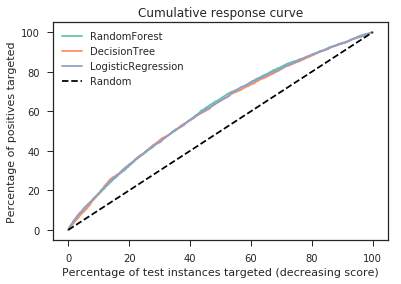

In [34]:
# Get the predicted value and the probability of Y_test records being = 1

RF_predictions = tuned_model.predict(X_mailing_test)
DT_predictions = tuned_model1.predict(X_mailing_test)
LR_predictions = tuned_model2.predict(X_mailing_test)

RF_predict = tuned_model.predict_proba(X_mailing_test)[:, 1]
DT_predict = tuned_model1.predict_proba(X_mailing_test)[:, 1]
LR_predict = tuned_model2.predict_proba(X_mailing_test)[:, 1]

order = np.argsort(RF_predict)[::-1]
orderD = np.argsort(DT_predict)[::-1]
orderL = np.argsort(LR_predict)[::-1]

Y_test_predicted_sortedRF = RF_predictions[order]
Y_test_predicted_sortedDT = DT_predictions[orderD]
Y_test_predicted_sortedLR = LR_predictions[orderL]

Y_test_sorted = np.array(y_mailing_use_secret)[order]
Y_test_sortedD = np.array(y_mailing_use_secret)[orderD]
Y_test_sortedL = np.array(y_mailing_use_secret)[orderL]

total_test_positives = y_mailing_use_secret.sum()

y_cumulative = Y_test_sorted.cumsum()*100/float(total_test_positives)
y_cumulativeD = Y_test_sortedD.cumsum()*100/float(total_test_positives)
y_cumulativeL = Y_test_sortedL.cumsum()*100/float(total_test_positives)

x_cumulative = np.linspace(1, len(y_cumulative), len(y_cumulative))*100/len(y_cumulative)

# Plot
plt.plot(x_cumulative, y_cumulative, label="RandomForest")
plt.plot(x_cumulative, y_cumulativeD, label="DecisionTree")
plt.plot(x_cumulative, y_cumulativeL, label="LogisticRegression")
plt.plot([0,100], [0,100], 'k--', label="Random")
plt.xlabel("Percentage of test instances targeted (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Cumulative response curve")
plt.legend()
plt.show()

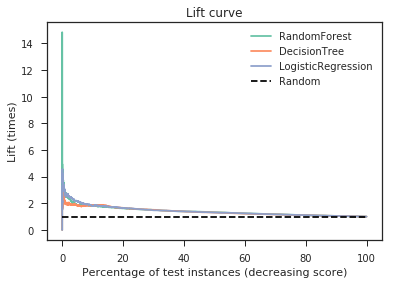

In [35]:
# Lift Curve Chart
y_lift = y_cumulative/x_cumulative
y_liftDT = y_cumulativeD/x_cumulative
y_liftLR = y_cumulativeL/x_cumulative

plt.plot(x_cumulative, y_lift, label="RandomForest")
plt.plot(x_cumulative, y_liftDT, label="DecisionTree")
plt.plot(x_cumulative, y_liftLR, label="LogisticRegression")
plt.plot([0,100], [1,1], 'k--', label="Random")
plt.xlabel("Percentage of test instances (decreasing score)")
plt.ylabel("Lift (times)")
plt.title("Lift curve")
plt.legend()
plt.show()

**3.** How many positive responders (`y_mailing_use_secret == 1`) would you have selected if you targeted the top 1%, 5% and 10% of your audience? How do these compare?

In [36]:
print( 'RandomForest: \
\nTop 1% -> {} positive responders'.format( sum(Y_test_sorted[:int(len(Y_test_sorted)*.01)]) ),
'\nTop 5% -> {} positive responders'.format( sum(Y_test_sorted[:int(len(Y_test_sorted)*.05)]) ),
'\nTop 10%-> {} positive responders'.format( sum(Y_test_sorted[:int(len(Y_test_sorted)*.1)]) ),
'\nMax out Budget 1,500 -> {}'.format( sum(Y_test_sorted[:1500]) )
)
print( '\nDecisionTree: \
\nTop 1% -> {} positive responders'.format( sum(Y_test_sortedD[:int(len(Y_test_sortedD)*.01)]) ),
'\nTop 5% -> {} positive responders'.format( sum(Y_test_sortedD[:int(len(Y_test_sortedD)*.05)]) ),
'\nTop 10%-> {} positive responders'.format( sum(Y_test_sortedD[:int(len(Y_test_sortedD)*.1)]) ),
'\nMax out Budget 1,500 -> {}'.format( sum(Y_test_sorted[:1500]) )
)
print( '\nLogisticRegression: \
\nTop 1% -> {} positive responders'.format( sum(Y_test_sortedL[:int(len(Y_test_sortedL)*.01)]) ),
'\nTop 5% -> {} positive responders'.format( sum(Y_test_sortedL[:int(len(Y_test_sortedL)*.05)]) ),
'\nTop 10%-> {} positive responders'.format( sum(Y_test_sortedL[:int(len(Y_test_sortedL)*.1)]) ),
'\nMax out Budget 1,500 -> {}'.format( sum(Y_test_sorted[:1500]) )
)

RandomForest: 
Top 1% -> 68 positive responders 
Top 5% -> 224 positive responders 
Top 10%-> 444 positive responders 
Max out Budget 1,500 -> 163

DecisionTree: 
Top 1% -> 48 positive responders 
Top 5% -> 221 positive responders 
Top 10%-> 453 positive responders 
Max out Budget 1,500 -> 163

LogisticRegression: 
Top 1% -> 64 positive responders 
Top 5% -> 259 positive responders 
Top 10%-> 438 positive responders 
Max out Budget 1,500 -> 163


In [37]:
# #sum(Y_test_predicted_sortedRF)
# mailing_conf_matrix_two = metrics.confusion_matrix(y_mailing_use_secret, RF_predictions, labels=[1, 0]).T
# # Build and print a confusion matrix
# confusion_matrix_small = pd.DataFrame(mailing_conf_matrix_two,
#                                       columns=['p', 'n'], index=['Y', 'N'])
# print (confusion_matrix_small)
# #metrics.confusion_matrix(y_mailing_use_secret, RF_predictions, labels=[1, 0]).T
# #sum(Y_test_predicted_sortedRF)
# mailing_conf_matrix_two = metrics.confusion_matrix(y_mailing_use_secret, DT_predictions, labels=[1, 0]).T
# # Build and print a confusion matrix
# confusion_matrix_small = pd.DataFrame(mailing_conf_matrix_two,
#                                       columns=['p', 'n'], index=['Y', 'N'])
# print (confusion_matrix_small)
# #metrics.confusion_matrix(y_mailing_use_secret, RF_predictions, labels=[1, 0]).T
# #sum(Y_test_predicted_sortedRF)
# mailing_conf_matrix_two = metrics.confusion_matrix(y_mailing_use_secret, LR_predictions, labels=[1, 0]).T
# # Build and print a confusion matrix
# confusion_matrix_small = pd.DataFrame(mailing_conf_matrix_two,
#                                       columns=['p', 'n'], index=['Y', 'N'])
# print (confusion_matrix_small)
# #metrics.confusion_matrix(y_mailing_use_secret, RF_predictions, labels=[1, 0]).T

**4.** Assume that the amount that people donate is $10.  Compute the profit for each of the three thresholds.  Construct a cumulative profit curve for the mailing campaign using your chosen model.
  
How many people would you have wanted to target if you were trying to maximize your total expected profit?  What would the total profit be?

What about if you just wanted to “break even”?  Imagine your budget for targeted marketing is \$3000. What is your profit for this \$3000 budget?  Does this budget make business sense for these data?  Make a recommendation for what to do.

Now, think about the fact that in practice you would not know `y_mailing_use_secret`.  Explain how you would select the threshold to use to maximize your (expected) profit.


Optional: Do that! Choose the threshold to maximize your expected profit and see how close you would come to the actual maximum on the use data.

In [41]:
# revenue: $30 ; cost: $2 ; profit: $8
cost_benefit_matrix = np.array([[28, -2], [0, 0]])
cost_benefit_matrix

array([[28, -2],
       [ 0,  0]])

In [42]:
def compute_expected_cost(confusion_matrix, cost_matrix):
    conf_probabilities = confusion_matrix/float(confusion_matrix.sum())
    costs = conf_probabilities*cost_matrix
    return costs.sum()

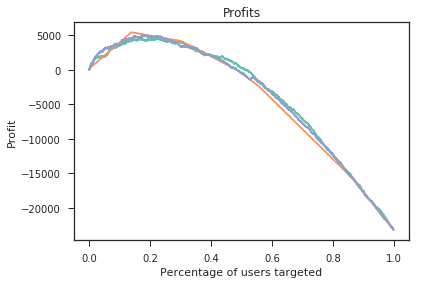

In [43]:
# Profit Curve

# fpr, tpr, thresholds
# fprD, tprD, thresholdsD
# fprL, tprL, thresholdsL

# RF_predictions
# DT_predictions
# LR_predictions

# RF_predict
# DT_predict
# LR_predict

#thresholds #== 
#thresholdsD
#thresholdsL

# Get the false positive rate, true positive rate, and all thresholds
size_targeted_pop = float(len(y_mailing_use_secret))

# What is the baseline probability of being positive or negative in the data set?
p_p = y_mailing_use_secret.sum()/float(len(y_mailing_use_secret))
p_n = 1 - y_mailing_use_secret.sum()/float(len(y_mailing_use_secret))

#Y_test_predicted = model.predict(X_test)
#Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

# How many users are above the current threshold?
n_targeted = []
for t in thresholds:
    n_targeted.append(np.sum(RF_predict >= t))

n_targetedD = []
for t in thresholdsD:
    n_targetedD.append(np.sum(DT_predict >= t))

n_targetedL = []
for t in thresholdsL:
    n_targetedL.append(np.sum(LR_predict >= t))

# Turn these counts to percentages of users above the threshold
n_targeted = np.array(n_targeted)/float(len(y_mailing_use_secret))
n_targetedD = np.array(n_targetedD)/float(len(y_mailing_use_secret))
n_targetedL = np.array(n_targetedL)/float(len(y_mailing_use_secret))

# Expected profits:  
expected_profits = (cost_benefit_matrix[0, 0]*(tpr*p_p)) + (cost_benefit_matrix[0, 1]*(fpr*p_n))
expected_profitsD = (cost_benefit_matrix[0, 0]*(tprD*p_p)) + (cost_benefit_matrix[0, 1]*(fprD*p_n))
expected_profitsL = (cost_benefit_matrix[0, 0]*(tprL*p_p)) + (cost_benefit_matrix[0, 1]*(fprL*p_n))


# Plot the profit curve
plt.plot(n_targeted, size_targeted_pop*expected_profits)
plt.plot(n_targetedD, size_targeted_pop*expected_profitsD)
plt.plot(n_targetedL, size_targeted_pop*expected_profitsL)
plt.xlabel("Percentage of users targeted")
plt.ylabel("Profit")
plt.title("Profits")
plt.show()

In [70]:
profitmax = max(zip(size_targeted_pop*expected_profits, n_targeted) ) 

In [105]:
BreakEven = [ (x,c) for x,c in zip(size_targeted_pop*expected_profits, n_targeted) if x>=-1 and x<=1  ]

In [106]:
MaxBudget= [ (x,c) for x,c in zip(size_targeted_pop*expected_profits, n_targeted) if abs(c*size_targeted_pop-1500) <2 ]

In [121]:
print("""To maximize expected profit I would target {} prospects for a total expected profit of ${}.""".format(
 profitmax[1]*size_targeted_pop,round(profitmax[0],2)),
"""\n\nIf wanted to break even I would target {} prospects.""".format(BreakEven[1][1]*size_targeted_pop) ,
"""\n\nGiven that I have only $3k in my budget I canly only target 1500 people ($2 cost per target) I can expect
to generate ${} with my current budget.
\nI recommend increasing my budget because based on the data there is a lot more profit to be made.
""".format(round(MaxBudget[0][0],2)))

To maximize expected profit I would target 10748.0 prospects for a total expected profit of $4634.0. 

If wanted to break even I would target 24675.0 prospects. 

Given that I have only $3k in my budget I canly only target 1500 people ($2 cost per target) I can expect
to generate $1892.0 with my current budget.

I recommend increasing my budget because based on the data there is a lot more profit to be made.

